In [1]:
import numpy as np
import itertools
import pandas as pd
import os 
import jax.numpy as jnp
import matplotlib.pyplot as plt


# print(jnp.logspace(-6, -1, 15)[:])

devs = np.logspace(-6, -1, 15)[:]


# print(os.listdir("../../results/Gaussian_MAMS_Paper"))
integrator_types = ['velocity_verlet'
                    # , 'mclachlan', 
                    # 'omelyan'
                    ]

samplers = [[
    
    # f"adjusted_microcanonical_{integrator_type}", 
    # f"unadjusted_microcanonical__{integrator_type}",
    f"underdamped_langevin_{dev}",
    # f"adjusted_hmc_{integrator_type}",
    # f"adjusted_malt",
    

                
                ] for dev in devs]

samplers = [
    x
    for xs in samplers
    for x in xs
]


# grid_samplers = [
#     [
#         f"grid_search_unadjusted_lmc_{integrator_type}",
    
# #     f"grid_search_adjusted_microcanonical_{integrator_type}",
# #     f"grid_search_unadjusted_microcanonical_{integrator_type}",
#      ] for integrator_type in integrator_types]


# Ds = np.concatenate([np.arange(2,10), np.ceil(np.logspace(2,4, 5)).astype(int)])[:]
# models = [f"Rosenbrock_{D*2}" for D in Ds]


models = [f"ICG"]



df_tuned = pd.concat([pd.read_csv(f"../../results/Gaussian_MAMS_Paper/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, models)], ignore_index=True)
df_tuned_brownian = pd.concat([pd.read_csv(f"../../results/vector_brownian_motion_unknown_scales_missing_middle_observations/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, ["vector_brownian_motion_unknown_scales_missing_middle_observations"])], ignore_index=True)
df_tuned_rosenbrock = pd.concat([pd.read_csv(f"../../results/rosenbrock_36d/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, ["rosenbrock_36d"])], ignore_index=True)
# df_tuned = pd.concat([pd.read_csv(f"results/tuned/Rosenbrock/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, models)], ignore_index=True)
df_tuned_german_credit = pd.concat([pd.read_csv(f"../../results/vector_german_credit_numeric_sparse_logistic_regression/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, ["vector_german_credit_numeric_sparse_logistic_regression"])], ignore_index=True)

df = df_tuned_rosenbrock

# df_grid = pd.concat([pd.read_csv(f"results/grid_search/Gaussian/{sampler}_{model}.csv") for sampler, model in itertools.product(samplers, models)], ignore_index=True)

# df["dim"] = df["Model"].str.extract(r"(\d+)").astype(int)
df['dev'] = df['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df = df[df["max"] == False]
df = df[(df["statistic"] == 'square')]
df['Integrator'] = df['Sampler'].apply(lambda x: x.split('_')[-1])
# df['Sampler'] = df['Sampler'].apply(lambda x: x.split('_')[0]+x.split('_')[1]+x.split('_')[2] if x[0]=='g' else x.split('_')[0])
# df['Sampler'] = df['Sampler'].apply({
#     'unadjusted_microcanonical__velocity_verlet': 'unadjusted_microcanonical_velocity_verlet',
#     'adjusted_microcanonical_velocity_verlet': 'adjusted_microcanonical_velocity_verlet',
#     'underdamped_langevin_velocity_verlet': 'underdamped_langevin_velocity_verlet',
#     'adjusted_hmc_velocity_verlet': 'adjusted_hmc_velocity_verlet',
#     'adjusted_malt': 'adjusted_malt',
# }.get)
df['ESS'] = 100/df["num_grads_to_low_error"]
df= df[df['Integrator']=='velocity_verlet']
# df=df[df["Sampler"]=='adjusted_microcanonical_velocity_verlet']


In [2]:
df_rosenbrock = df_tuned_rosenbrock[(df_tuned_rosenbrock["max"] == False) & (df_tuned_rosenbrock["statistic"] == 'square')]
df_rosenbrock = df_rosenbrock[4:]

df_brownian = df_tuned_brownian.copy()
df_brownian['dev'] = df_brownian['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df_brownian = df_brownian[df_brownian["max"] == False]
df_brownian = df_brownian[(df_brownian["statistic"] == 'square')]

df_tuned_german_credit['dev'] = df_tuned_german_credit['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df_tuned_german_credit = df_tuned_german_credit[df_tuned_german_credit["max"] == False]
df_tuned_german_credit = df_tuned_german_credit[(df_tuned_german_credit["statistic"] == 'square')]


df_tuned['dev'] = df_tuned['Sampler'].apply(lambda x: float(x.split('_')[-1]))
df_tuned = df_tuned[df_tuned["max"] == False]
df_tuned = df_tuned[(df_tuned["statistic"] == 'square')]


models = {
    'Gaussian': (df_tuned, 1830, 'tab:blue'),
    'Rosenbrock': (df_rosenbrock, 8410, 'tab:red'),
    'Brownian Motion': (df_brownian, 2407, 'tab:brown'),
    'German Credit': (df_tuned_german_credit, 4423, 'tab:purple'),
}

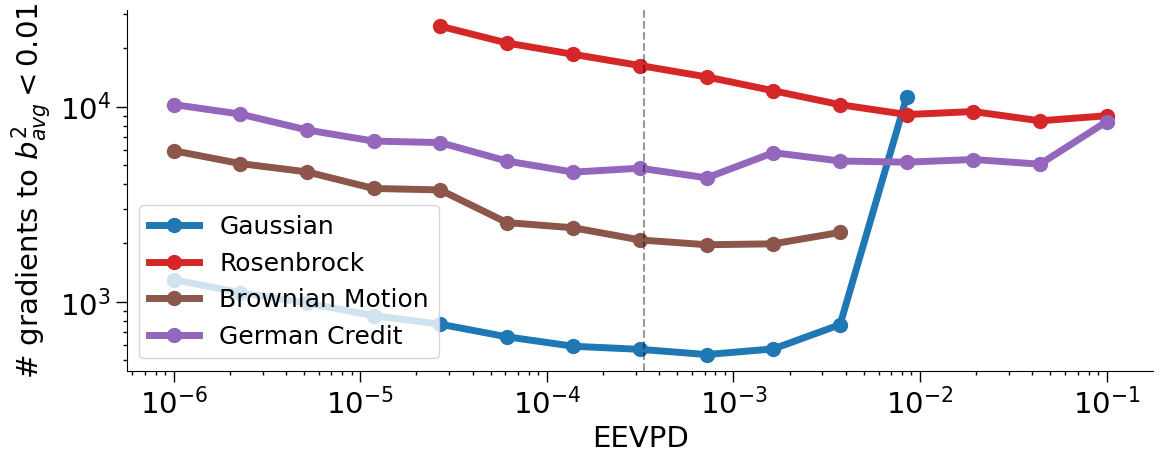

In [6]:
ff = 21
plt.rcParams['xtick.labelsize'] = ff
plt.rcParams['ytick.labelsize'] = ff
plt.rcParams['font.size'] = ff
plt.figure(figsize= (12, 5))
plt.gca().spines[['right', 'top']].set_visible(False)


for model, (df_model, grid_search, color) in models.items():
    plt.plot(df_model['dev'], df_model['num_grads_to_low_error'], 'o-', lw = 5, markersize= 10, color= color, label= model)
    #vale = df_model['dev'].iloc[np.argmin(np.array(df_model['num_grads_to_low_error']))]
    #plt.plot([vale, ], [grid_search, ], '*', color= color, markersize= 10) 

plt.xlabel('EEVPD')
plt.ylabel(r'# gradients to $b_{\mathit{avg}}^2 < 0.01$')

plt.yscale('log')
plt.xscale('log')
plt.axvline(x = 3.3e-4, color = 'black', linestyle = '--', alpha = 0.4)  
plt.legend(loc= 3, fontsize = 18)

plt.tight_layout()
plt.gca().tick_params('both', length=8, width=1, which='major')
plt.gca().tick_params('both', length=3, width=1, which='minor')
plt.savefig('ablation.pdf', dpi= 500)
plt.show()